# Predição da produtividade da cana-de-açúcar no estado de São Paulo

Este projeto faz parte do TCC em Data Science and Analytics da ESALQ/USP. Neste projeto, meu principal objetivo é predizer a produtividade da cana-de-açúcar nos municípios do Estado de São Paulo, utilizando para isso séries históricas de 21 anos e outras variáveis ambientais.

Todos os dados sobre a produtividade (kg/ha), área plantada (ha), área colhida (ha), quantidade produzida (tn) e valor da produção (R$) foram obtidos do site SIDRA, do IBGE. Os dados sobre variaveis climáticas, de vegetação e solos foram obtidos no Google Earth Engine de várias fontes, na forma de raster. A média de cada raster foi calculada para cada município. Entre as varíaveis utilizadas estão a temperatura mínima, máxima, precipitação acumulada e umidade do solo, extraídas do TERRACLIMATE. O NDVI (Normalized Difference Vegetation Index), NPP (Net Primary Productivity) e LST (Land surface temperature) foram obtidos do MODIS. 

A seguir, uma descrição dos principais pasos será fornecida. A primeira é sobre o tratamento das tabelas do IBGE e posteriormente sobre as variáveis ambientais. 

## Parte 1: Análise exploratória e limpeza de dados obtidos da página do IBGE

Nessa primeira parte iremos analisar os dados de produtividade para cada município. Os pasos consistem em separar o csv original em cada uma das tabelas e preencher os valores ausentes

In [1]:
# Carregar libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import geopandas as gp
import earthpy.plot as ep
import missingno
import folium
import rioxarray
import xarray
import sys
import warnings
import rasterio
import seaborn as sns
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from shapely import geometry
from linearmodels.panel import PanelOLS
pd.set_option('display.max_rows', None)

In [ ]:
# Carregar dados e criar 'chunks' para cada tabela. Salvar separadamente no computador
for i, chunk in enumerate(pd.read_csv('tabela1612.csv',  encoding ='ISO-8859-1', decimal = ',', sep = ';', chunksize=648)):
    chunk.to_csv('chunk{}.csv'.format(i), index=False, encoding ='ISO-8859-1', decimal = '.')

No final da tabela original temos as descrições seguintes:

  - Zero absoluto, não resultante de um cálculo ou arredondamento (-) 
  - Zero resultante de um cálculo ou arredondamento (0)
  - Valor não se aplica. Ex: Não se pode obter o total da produção agrícola em determinado município quando os produtos agrícolas são contabilizados com unidades de medida distintas (..)
  - Valor não disponível. Ex: A produção de feijão em determinado município não foi pesquisada ou determinado município não existia no ano da pesquisa (...)
  
Após conferir os dados de produtividade com os dados de área plantada, foi possível observar que os municípios que não tem valores numéricos e apresentam algum dos símbolos mencionados acima, não possuem valor de produtivade por algúm dos motivos já mencionados, más principalmente porque não houve registro de área plantada. Então, iremos utilizar duas estratégias, sendo que a primeira será reemplazar todos os símbolos com espaço ou branco ou NaN que depois será preenchido com a média, para completar todos os espaços. A segunda estratégia será utilizar os dados com os NaNs.

O primeiro paso então é substituir os símbolos por 'NaN'


### Carregar as tabelas produtividade (kg/ha), area plantada (ha), area colhida (ha), quantidade produzida (tn) e valor da produção (R$)

In [2]:
# Carregar a tabela que contem a produtividade da cana de açúcar para cada ano. Excluir as primeiras 4 linhas e as ultimas 2.
# Criar uma lista com os símbolos que representam os valores ausentes e utilizar esta lista para substituir NAs.
lista_ausentes = ['-', '..', '...']
dat_yield = pd.read_csv("tables/chunk5.csv", skiprows = 3, na_values = lista_ausentes).drop([0, 643, 644])
dat_yield.reset_index(drop = True, inplace = True)
dat_yield.rename(columns = {'Cód.': 'CD_MUN', 'Município': 'MUN'}, inplace = True)
dat_yield.head()

,CD_MUN,MUN,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3500105,Adamantina (SP),50000,80000,76311,77794,80000,81307,75000,100000,...,75000,60000,70000,60000,80000,80000,80000,70000,75000,70000
1,3500204,Adolfo (SP),NaN,80000,NaN,NaN,120000,89009,100000,100000,...,90000,90000,90000,70000,70000,80000,90000,90000,90000,90000
2,3500303,Aguaí (SP),80000,NaN,87000,86089,86000,85434,85000,85000,...,90000,90000,100000,100000,80000,90000,90000,85000,85000,85000
3,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000,90000,90000,90000,NaN,NaN,NaN,NaN,NaN,NaN
4,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
dat_ap = pd.read_csv("tables/chunk0.csv", skiprows = 3, na_values = lista_ausentes).drop([0, 643, 644])
dat_ap.reset_index(drop = True, inplace = True)
dat_ap.rename(columns = {'Cód.': 'CD_MUN', 'Município': 'MUN'}, inplace = True)
dat_ap.head()

,CD_MUN,MUN,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3500105,Adamantina (SP),7000,7000,8048,7644,8300,8603,8000,12000,...,13000,13000,13000,12115,12950,12900,12800,13000,12500,11349
1,3500204,Adolfo (SP),NaN,8000,NaN,NaN,968,1104,1114,3418,...,4461,4461,4461,6209,6309,5809,7320,7266,7016,5015
2,3500303,Aguaí (SP),5250,NaN,4200,7180,7850,7664,10200,8000,...,12000,12500,12500,12500,12500,12500,12500,11500,11500,11500
3,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,85,70,70,70,NaN,NaN,NaN,NaN,NaN,NaN
4,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
dat_ac = pd.read_csv("tables/chunk2.csv", skiprows = 3, na_values = lista_ausentes).drop([0, 643, 644])
dat_ac.reset_index(drop = True, inplace = True)
dat_ac.rename(columns = {'Cód.': 'CD_MUN', 'Município': 'MUN'}, inplace = True)
dat_ac.head()

,CD_MUN,MUN,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3500105,Adamantina (SP),7000,7000,8048,7644,8300,8603,8000,12000,...,13000,13000,13000,12115,12950,12900,12800,13000,12500,11349
1,3500204,Adolfo (SP),NaN,8000,NaN,NaN,968,1104,1114,3418,...,4461,4461,4461,6209,6309,5809,7320,7266,7016,5015
2,3500303,Aguaí (SP),5250,NaN,4200,7180,7850,7664,10200,8000,...,12000,12500,12500,12500,12500,12500,12500,11500,11500,11500
3,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,85,70,70,70,NaN,NaN,NaN,NaN,NaN,NaN
4,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
dat_qp = pd.read_csv("tables/chunk4.csv", skiprows = 3, na_values = lista_ausentes).drop([0, 643, 644])
dat_qp.reset_index(drop = True, inplace = True)
dat_qp.rename(columns = {'Cód.': 'CD_MUN', 'Município': 'MUN'}, inplace = True)
dat_qp.head()

,CD_MUN,MUN,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3500105,Adamantina (SP),350000,560000,614158,594663,664000,699491,600000,1200000,...,975000,780000,910000,726900,1036000,1032000,1024000,910000,937500,794430
1,3500204,Adolfo (SP),NaN,640000,NaN,NaN,116160,98267,111400,341800,...,401490,401490,401490,434630,441630,464720,658800,653940,631440,451350
2,3500303,Aguaí (SP),420000,NaN,365400,618126,675100,654770,867000,680000,...,1080000,1125000,1250000,1250000,1000000,1125000,1125000,977500,977500,977500
3,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5100,6300,6300,6300,NaN,NaN,NaN,NaN,NaN,NaN
4,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
dat_vp = pd.read_csv("tables/chunk6.csv", skiprows = 3, na_values = lista_ausentes).drop([0, 643, 644])
dat_vp.reset_index(drop = True, inplace = True)
dat_vp.rename(columns = {'Cód.': 'CD_MUN', 'Município': 'MUN'}, inplace = True)
dat_vp.head()

,CD_MUN,MUN,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3500105,Adamantina (SP),6244,13294,18713,19029,15936,20110,19800,37200,...,40950,49600,55965,43003,61756,59330,60467,55783,60094,51709
1,3500204,Adolfo (SP),NaN,15194,NaN,NaN,2765,3484,3609,10596,...,21680,22098,22138,21975,23680,31633,45872,43082,44700,32497
2,3500303,Aguaí (SP),7493,NaN,11134,16689,16202,18334,27744,24480,...,42120,69210,75325,70250,53530,67568,68625,63538,66793,70869
3,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,189,370,380,357,NaN,NaN,NaN,NaN,NaN,NaN
4,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Tamanho dos datasets
print('A tabela com dados da produtividade (kg/ha) tem {} linhas e {} colunas'.format(dat_yield.shape[0], dat_yield.shape[1]))
print('A tabela com dados da área plantada (ha) tem {} linhas e {} colunas'.format(dat_ap.shape[0], dat_ap.shape[1]))
print('A tabela com dados da área colhida (kg/ha) tem {} linhas e {} colunas'.format(dat_ac.shape[0], dat_ac.shape[1]))
print('A tabela com dados da quantidade produzida (tn) tem {} linhas e {} colunas'.format(dat_qp.shape[0], dat_qp.shape[1]))
print('A tabela com dados do valor da produção (Mil reais) tem {} linhas e {} colunas'.format(dat_vp.shape[0], dat_vp.shape[1]))

A tabela com dados da produtividade (kg/ha) tem 642 linhas e 23 colunas
A tabela com dados da área plantada (ha) tem 642 linhas e 23 colunas
A tabela com dados da área colhida (kg/ha) tem 642 linhas e 23 colunas
A tabela com dados da quantidade produzida (tn) tem 642 linhas e 23 colunas
A tabela com dados do valor da produção (Mil reais) tem 642 linhas e 23 colunas


In [ ]:
dat_yield.info()

In [ ]:
dat_ap.info()

In [ ]:
dat_ac.info()

In [ ]:
dat_qp.info()

In [ ]:
dat_vp.info()

Todas as colunas foram lidas como 'object'. Por isso precisamos converter para numerico

In [8]:
# Selecionar as colunas a converter, usar somente um df
cols = dat_yield.columns.drop(['CD_MUN', 'MUN']).tolist()

In [9]:
# Converter colunas para tipo numerico
dat_yield[cols] = dat_yield[cols].apply(pd.to_numeric)
dat_ap[cols] = dat_ap[cols].apply(pd.to_numeric)
dat_ac[cols] = dat_ac[cols].apply(pd.to_numeric)
dat_qp[cols] = dat_qp[cols].apply(pd.to_numeric)
dat_vp[cols] = dat_vp[cols].apply(pd.to_numeric)
dat_vp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CD_MUN  642 non-null    object 
 1   MUN     642 non-null    object 
 2   2000    381 non-null    float64
 3   2001    383 non-null    float64
 4   2002    419 non-null    float64
 5   2003    421 non-null    float64
 6   2004    440 non-null    float64
 7   2005    450 non-null    float64
 8   2006    467 non-null    float64
 9   2007    483 non-null    float64
 10  2008    506 non-null    float64
 11  2009    500 non-null    float64
 12  2010    522 non-null    float64
 13  2011    530 non-null    float64
 14  2012    491 non-null    float64
 15  2013    515 non-null    float64
 16  2014    511 non-null    float64
 17  2015    508 non-null    float64
 18  2016    512 non-null    float64
 19  2017    514 non-null    float64
 20  2018    518 non-null    float64
 21  2019    517 non-null    float64
 22  20

Na informação apresentada para cada tabela é possível observar que não temos dados para todos os Municípios em todos os anos. Se completo, o total para todas as colunas deveria ser de 642, na coluna do meio. Portanto, vemos que há muitos dados faltantes. Nos próximos códigos vamos analisar esses dados faltantes somente na tabela da produtividade (dat_yield). Iremos excluir as linhas que não tem valores de produtividade para todos os anos e aqueles com mais de 40% de valores ausentes. Após a exclusão destes valores, as linhas restantes com o código do  município foram utilizadas para selecionar os municípios das demais tabelas e ter um banco de dados similar.

### Conferir valores ausentes

In [10]:
# Função para calcular o total de valores ausentes
def calc_ausentes(df):

    # Total de valores no dataset
    total_values = np.product(df.shape)

    # Numero de valores ausentes por coluna
    colvalues_missing = df.isnull().sum()

    # Total de valores ausentes e percentagem
    missing_total = colvalues_missing.sum()
    missing_percent = round(((missing_total/total_values) * 100), 2)

    # Print resultado
    print('O conjunto de dados tem {} % valores ausentes'.format(missing_percent))
    
    
# Função para calcular valores ausentes por coluna
def cal_ausentes_coluna(df):
    
    # Numero de valores ausentes por coluna
    col_missing = df.isnull().sum()

    # Porcentagem de valores ausentes
    col_missing_percent = 100 * col_missing / len(df)

    # Tipo de dado das colunas com valores ausentes
    col_missing_dtype = df.dtypes

    # Cria uma tabela com os resultados
    col_missing_table = pd.concat([col_missing, col_missing_percent, col_missing_dtype], axis=1)

    # Renomear as colunas
    col_missing_table = col_missing_table.rename(
    columns = {0 : 'Valores Ausentes', 1 : '% de Valores Ausentes', 2: 'Dtype'})

    # Classifica a tabela por porcentagem de valores ausentes de forma decrescente e remove colunas sem valores faltantes
    col_missing_table = col_missing_table[\
                                          col_missing_table.iloc[:,0] != 0].sort_values('% de Valores Ausentes', \
                                                                                        ascending = False).round(2)

    # Print 
    print ("O dataset tem " + str(df.shape[1]) + " colunas.\n"
        "Encontrado: " + str(col_missing_table.shape[0]) + " colunas que têm valores ausentes.")

    if col_missing_table.shape[0] == 0:
        return

    # Retorna o dataframe com informações ausentes
    return col_missing_table

# Função que calcula o percentual de linhas com valores ausentes
def calc_ausentes_linha(df):

    # Calcula o número total de linhas com valores ausentes
    missing_rows = sum([True for idx, row in df.iterrows() if any(row.isna())])

    # Calcula o número total de linhas
    total_rows = df.shape[0]

    # Calcula a porcentagem de linhas ausentes
    percen_ausentes = round(((missing_rows/total_rows) * 100), 2)
    
    print('O dataset tem {} % das linhas com pelo menos um valor ausente.'.format(percen_ausentes))

In [11]:
# Verifica o percentual de valores ausentes
calc_ausentes(dat_yield)

O conjunto de dados tem 22.89 % valores ausentes


In [12]:
# Verificar os valores ausentes nas colunas
cal_ausentes_coluna(dat_yield)      

O dataset tem 23 colunas.
Encontrado: 21 colunas que têm valores ausentes.


,Valores Ausentes,% de Valores Ausentes,Dtype
2000,261,40.65,float64
2001,259,40.34,float64
2002,224,34.89,float64
2003,221,34.42,float64
2004,204,31.78,float64
2005,192,29.91,float64
2006,175,27.26,float64
2007,159,24.77,float64
2012,151,23.52,float64
2009,142,22.12,float64


In [13]:
# Verificar os valores ausentes nas linhas
calc_ausentes_linha(dat_yield)

O dataset tem 51.09 % das linhas com pelo menos um valor ausente.


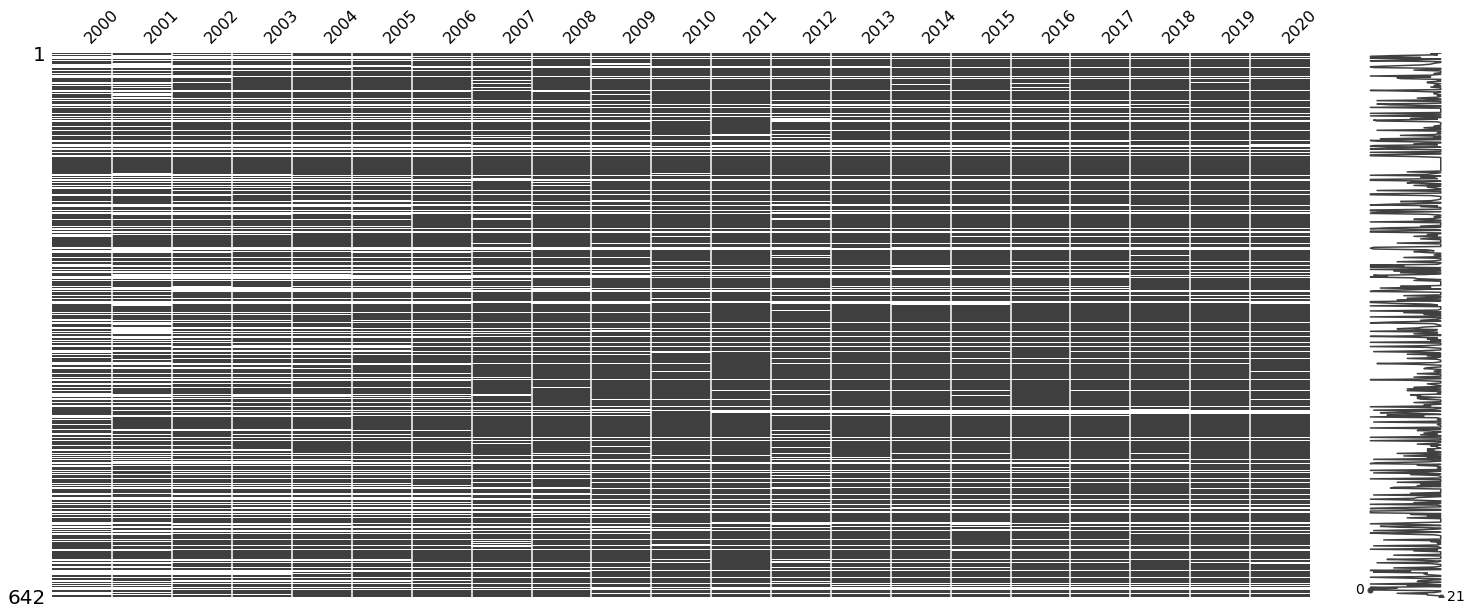

In [14]:
# Plotar mapa de valores ausentes
dat_yield_nan = pd.DataFrame(dat_yield.isna().sum())

if dat_yield.isna().any(axis = None):
    missingno.matrix(dat_yield[dat_yield_nan[dat_yield_nan[0]>0].index])
    plt.show()

Temos um padrão de variação nos dados. Há linhas inteiras com células vazias, o que quer dizer que vários municípios não produziram cana-de-açucar em nenhum dos anos estudados. Então, o paso seguinte é identificar a porcentagem desses valores ausentes em cada linha e coluna. A princípio iremos focar em deletar os valores ausentes nas linhas para todos os anos.

O que precisams fazer agora é contar os valores nulos para cada município, para ter certeza se são somente alguns valores faltando ou a porcentagem é maior. Se os valores ausentes em cada município representarem mais de 40%, o município será excluído da análise

In [15]:
# Contar as linhas com valores ausentes
missing_rows = sum([True for idx,row in dat_yield.iterrows() if any(row.isna())])
print("Temos {} linhas com valores ausentes".format(missing_rows))

Temos 328 linhas com valores ausentes


In [16]:
## Criar um dataframe com o cálculo da porcentagem de valores ausentes para cada linha
rows_missing = dat_yield.isnull().sum(axis=1)
rows_perc = round(((rows_missing / 21) * 100), 2)
mis_val_table = pd.concat([dat_yield['MUN'], rows_missing, rows_perc], axis = 1)
mis_val_table.rename(columns = {0: 'Total de ausentes', 1: 'Perc% de ausentes'}, inplace = True)
mis_val_table.head()

,MUN,Total de ausentes,Perc% de ausentes
0,Adamantina (SP),0,0.00
1,Adolfo (SP),3,14.29
2,Aguaí (SP),1,4.76
3,Águas da Prata (SP),15,71.43
4,Águas de Lindóia (SP),21,100.00


In [17]:
# Contar as linhas com 100% e > 50% de valores ausentes
rows_to_remove = mis_val_table[mis_val_table['Perc% de ausentes'] == 100].index.tolist()
rows_40perc = mis_val_table[mis_val_table['Perc% de ausentes'] >= 40.00].index.tolist()
print('Há {} linhas sem nenhum registro de produção de cana-de-açucar para todos os anos'.format(len(rows_to_remove)))
print('Há {} linhas com mais de 40% de valores ausentes'.format(len(rows_40perc)))

Há 68 linhas sem nenhum registro de produção de cana-de-açucar para todos os anos
Há 156 linhas com mais de 40% de valores ausentes


In [18]:
dat_yield.iloc[rows_40perc].head()

,CD_MUN,MUN,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
3,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000.0,90000.0,90000.0,90000.0,NaN,NaN,NaN,NaN,NaN,NaN
4,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3500600,Águas de São Pedro (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3500808,Alfredo Marcondes (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,3501301,Álvares Machado (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,75000.0,75000.0,75000.0,80000.0,100000.0,100000.0,100000.0


Após verificarmos os valores ausentes, concluímos que serão removidas 156 linhas.

In [19]:
# Remover as linhas com mais de 40% de valores ausentes
dat_yield_clean = dat_yield.drop(rows_40perc)
dat_yield_clean.shape

(486, 23)

Vamos plotar de novo o grafico para conferir o padrão dos valores ausentes

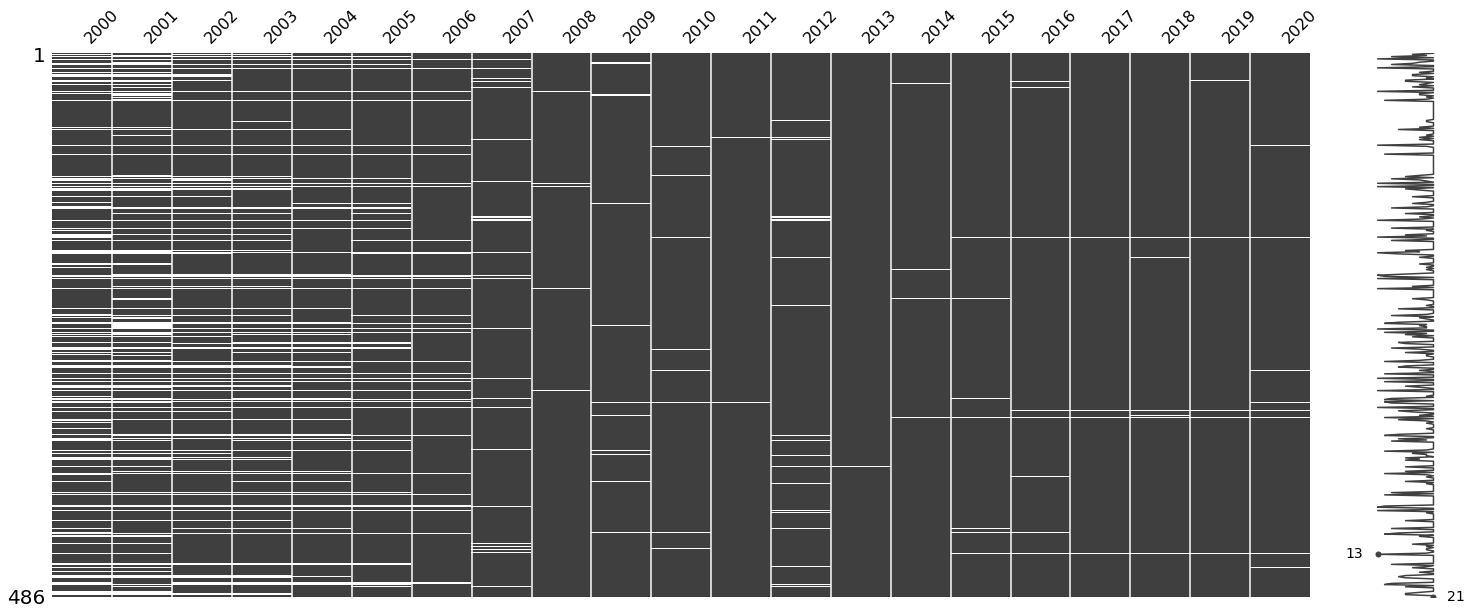

In [20]:
# Plot - Mapa de Valores Ausentes
dat_nan = pd.DataFrame(dat_yield_clean.isna().sum())

if dat_yield_clean.isna().any(axis = None):
    missingno.matrix(dat_yield_clean[dat_yield_nan[dat_yield_nan[0]>0].index])
    plt.show()

In [21]:
# Contar as linhas com valores ausentes
missing_rows = sum([True for idx,row in dat_yield_clean.iterrows() if any(row.isna())])
print("Temos {} linhas com valores ausentes". format(missing_rows))

Temos 172 linhas com valores ausentes


Até agora, identificamos valores ausentes e excluindo aqueles que não são úteis para nossa análise. Ainda temos 172 municípios com valores faltantes. No entanto, por enquanto, vamos deixá-lo e depois voltaremos a ele. Vamos a plotar um mapa de calor para ver os valores da produtividade.  
Para plotar corretamente os gráficos, os dados serão reformulados, usando a função de fusão. Isso criará um novo dataframe com todos os anos em uma única coluna.

In [22]:
# Name is id_vars and Course is value_vars
dat_clean_melt = pd.melt(dat_yield_clean, id_vars =['CD_MUN', 'MUN'])
heatmap_data = pd.pivot_table(dat_clean_melt,values='value', index=['MUN'], columns='variable')
heatmap_data.head()

variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
MUN,,,,,,,,,,,,,,,,,,,,,
Adamantina (SP),50000.0,80000.0,76311.0,77794.0,80000.0,81307.0,75000.0,100000.0,90000.0,80000.0,...,75000.0,60000.0,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0
Adolfo (SP),NaN,80000.0,NaN,NaN,120000.0,89009.0,100000.0,100000.0,80000.0,90000.0,...,90000.0,90000.0,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0
Aguaí (SP),80000.0,NaN,87000.0,86089.0,86000.0,85434.0,85000.0,85000.0,89080.0,90000.0,...,90000.0,90000.0,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0
Agudos (SP),70000.0,70000.0,70000.0,70000.0,77996.0,77723.0,80000.0,88669.0,80000.0,80000.0,...,79500.0,79500.0,79500.0,60004.0,64794.0,61000.0,70000.0,61000.0,70000.0,70000.0
Alambari (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75000.0,88888.0,...,92300.0,70000.0,80000.0,72800.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0


In [23]:
dat_clean_melt.shape

(10206, 4)

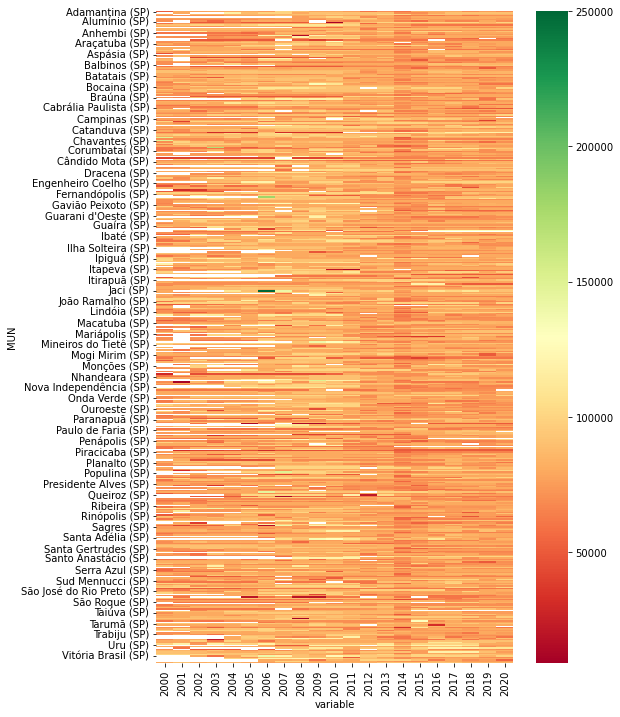

In [24]:
# Criando mapa de calor
plt.figure(figsize=(8, 12))
sns.heatmap(heatmap_data, cmap='RdYlGn')
plt.show()

Aqui podemos ver um outro problema. Tem produtividade acima de 200000 kg/ha, situação não muito comum e que pode atrapalhar a nossa análise. Por isso, vamos identificar esses municípios e excluir do banco de dados.

In [25]:
# Check de qual município tem acima de 200000 kg/ha
dat_yield_clean.loc[dat_yield_clean['2006'] >= 200000]

,CD_MUN,MUN,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
276,3524501,Jaci (SP),80000.0,NaN,NaN,NaN,110000.0,89396.0,250000.0,140000.0,...,90000.0,90000.0,100000.0,75000.0,90000.0,110000.0,100000.0,110000.0,90000.0,90000.0


In [26]:
# Excluir a linha pelo indice
dat_yield_clean.drop(276, inplace = True)

In [27]:
# Conferir se a linha foi excluida
dat_yield_clean.loc[dat_yield_clean['2006'] >= 200000]

,CD_MUN,MUN,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020


In [28]:
# Reset do index
dat_yield_clean.reset_index(drop = True, inplace = True)
dat_yield_clean.head()

,CD_MUN,MUN,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3500105,Adamantina (SP),50000.0,80000.0,76311.0,77794.0,80000.0,81307.0,75000.0,100000.0,...,75000.0,60000.0,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0
1,3500204,Adolfo (SP),NaN,80000.0,NaN,NaN,120000.0,89009.0,100000.0,100000.0,...,90000.0,90000.0,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0
2,3500303,Aguaí (SP),80000.0,NaN,87000.0,86089.0,86000.0,85434.0,85000.0,85000.0,...,90000.0,90000.0,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0
3,3500550,Águas de Santa Bárbara (SP),NaN,NaN,NaN,NaN,NaN,NaN,80333.0,80000.0,...,80000.0,100000.0,100000.0,100000.0,90000.0,63000.0,80000.0,70000.0,75000.0,55000.0
4,3500709,Agudos (SP),70000.0,70000.0,70000.0,70000.0,77996.0,77723.0,80000.0,88669.0,...,79500.0,79500.0,79500.0,60004.0,64794.0,61000.0,70000.0,61000.0,70000.0,70000.0


Agora não temos mais nenhum valor a excluir. Vamos a usar a lista de CD_MUN do dat_yield para selecionar as linhas nos demais datasets.

In [29]:
list_mun = dat_yield_clean['CD_MUN']
dat_ap_clean = dat_ap[dat_ap['CD_MUN'].isin(list_mun)].reset_index(drop = True)
dat_ac_clean = dat_ac[dat_ac['CD_MUN'].isin(list_mun)].reset_index(drop = True)
dat_qp_clean = dat_qp[dat_qp['CD_MUN'].isin(list_mun)].reset_index(drop = True)
dat_vp_clean = dat_vp[dat_ap['CD_MUN'].isin(list_mun)].reset_index(drop = True)
print('A tabela com dados da produtividade (kg/ha) tem {} linhas e {} colunas'.format(dat_yield_clean.shape[0], 
                                                                                      dat_yield_clean.shape[1]))
print('A tabela com dados da área plantada (ha) tem {} linhas e {} colunas'.format(dat_ap_clean.shape[0], 
                                                                                   dat_ap_clean.shape[1]))
print('A tabela com dados da área colhida (kg/ha) tem {} linhas e {} colunas'.format(dat_ac_clean.shape[0], 
                                                                                     dat_ac_clean.shape[1]))
print('A tabela com dados da quantidade produzida (tn) tem {} linhas e {} colunas'.format(dat_qp_clean.shape[0], 
                                                                                          dat_qp_clean.shape[1]))
print('A tabela com dados do valor da produção (Mil reais) tem {} linhas e {} colunas'.format(dat_vp_clean.shape[0], 
                                                                                              dat_vp_clean.shape[1]))

A tabela com dados da produtividade (kg/ha) tem 485 linhas e 23 colunas
A tabela com dados da área plantada (ha) tem 485 linhas e 23 colunas
A tabela com dados da área colhida (kg/ha) tem 485 linhas e 23 colunas
A tabela com dados da quantidade produzida (tn) tem 485 linhas e 23 colunas
A tabela com dados do valor da produção (Mil reais) tem 485 linhas e 23 colunas


Os bancos de dados estão prontos para serem unidos. O próximo paso é o reshape dos dados, usando a função melt. Após isso, um join

In [30]:
dat_yield_melt = pd.melt(dat_yield_clean, id_vars = ['CD_MUN', 'MUN'])
dat_yield_melt.rename(columns = {'variable': 'Year', 'value': 'Yield'}, inplace = True)
dat_ap_melt = pd.melt(dat_ap_clean, id_vars = ['CD_MUN', 'MUN'])
dat_ap_melt.rename(columns = {'variable': 'Year', 'value': 'AP'}, inplace = True)
dat_ac_melt = pd.melt(dat_ac_clean, id_vars = ['CD_MUN', 'MUN'])
dat_ac_melt.rename(columns = {'variable': 'Year', 'value': 'AC'}, inplace = True)
dat_qp_melt = pd.melt(dat_qp_clean, id_vars = ['CD_MUN', 'MUN'])
dat_qp_melt.rename(columns = {'variable': 'Year', 'value': 'QP'}, inplace = True)
dat_vp_melt = pd.melt(dat_vp_clean, id_vars = ['CD_MUN', 'MUN'])
dat_vp_melt.rename(columns = {'variable': 'Year', 'value': 'VP'}, inplace = True)
dat_vp_melt.shape

(10185, 4)

Após o reshape dos dados, as variáveis ambientais obtidas no Google Earth Engine e processadas no QGIS serão carregadas aqui, para fazer a junção com os dados do IBGE.

### Carregar as variáveis ambientais obtidas no GEE

In [31]:
# Carregar os arquivos das variavéis ambientais e criar um novo dataset somente com os IDs selecionados na celula anterior
list_mun = dat_yield_clean['CD_MUN'].astype(int).reset_index(drop = True)
aet = pd.read_csv('tables/aet.csv', sep = ';')
aet_new = aet[aet['CD_MUN'].isin(list_mun)].reset_index(drop = True)
ndvi = pd.read_csv('tables/ndvi.csv', sep = ';')
ndvi_new = ndvi[ndvi['CD_MUN'].isin(list_mun)].reset_index(drop = True)
npp = pd.read_csv('tables/npp.csv', sep = ';')
npp_new = npp[npp['CD_MUN'].isin(list_mun)].reset_index(drop = True)
soil = pd.read_csv('tables/soil.csv', sep = ';')
soil_new = soil[soil['CD_MUN'].isin(list_mun)].reset_index(drop = True)
pr = pd.read_csv('tables/pr.csv', sep = ';')
pr_new = pr[pr['CD_MUN'].isin(list_mun)].reset_index(drop = True)
lst = pd.read_csv('tables/LST.csv', sep = ';')
lst_new = lst[lst['CD_MUN'].isin(list_mun)].reset_index(drop = True)
tmmx = pd.read_csv('tables/tmmx.csv', sep = ';')
tmmx_new = tmmx[tmmx['CD_MUN'].isin(list_mun)].reset_index(drop = True)
tmin = pd.read_csv('tables/tmin.csv', sep = ';')
tmin_new = tmin[tmin['CD_MUN'].isin(list_mun)].reset_index(drop = True)

In [32]:
# Reformatar os conjunto de dados com a função melt
dat_clean_aet = pd.melt(aet_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_aet.rename(columns = {'value': 'AET'}, inplace = True)

dat_clean_ndvi = pd.melt(ndvi_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_ndvi.rename(columns = {'value': 'NDVI'}, inplace = True)

dat_clean_npp = pd.melt(npp_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_npp.rename(columns = {'value': 'NPP'}, inplace = True)

dat_clean_soil = pd.melt(soil_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_soil.rename(columns = {'value': 'SOIL'}, inplace = True)

dat_clean_pr = pd.melt(pr_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_pr.rename(columns = {'value': 'PR'}, inplace = True)

dat_clean_tmmx = pd.melt(tmmx_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_tmmx.rename(columns = {'value': 'TMMX'}, inplace = True)

dat_clean_tmin = pd.melt(tmin_new, id_vars =['CD_MUN']).reset_index(drop = True)
dat_clean_tmin.rename(columns = {'value': 'TMIN'}, inplace = True)

In [33]:
# Conferir o shape
dat_clean_tmin.shape

(10670, 3)

Vemos que as tabelas das variáveis ambientais tem mais linhas. Isso porque os dados vão até 2021, a diferneça das variavéis de produtividade, que temos somente até 2020. Quando for feito o join no codigo embaixo, o numero de linhas será o mesmo e o ano de 2021 será eliminado. Porém, como iremos utilizar o ano de 2021 como nosso conjunto de teste na modelagem, iremos salvar como um banco de dados separado. Para os dados de ap, ac, vp e qp ainda não temos dados de 2021. Por isso estes dados serão tratados mais a frente.

In [34]:
# Selecionar o ano de 2021
dat_aet_2021 = dat_clean_aet.tail(485)
dat_ndvi_2021 = dat_clean_ndvi.tail(485)
dat_npp_2021 = dat_clean_npp.tail(485)
dat_pr_2021 = dat_clean_pr.tail(485)
dat_soil_2021 = dat_clean_soil.tail(485)
dat_tmmx_2021 = dat_clean_tmmx.tail(485)
dat_tmin_2021 = dat_clean_tmin.tail(485)

In [35]:
# Juntar todos os dados
new_data = dat_yield_melt.join([dat_ap_melt['AP'], dat_ac_melt['AC'], dat_qp_melt['QP'], dat_vp_melt['VP'],
                               dat_clean_aet['AET'], dat_clean_ndvi['NDVI'], dat_clean_npp['NPP'], dat_clean_soil['SOIL'],
                                dat_clean_tmin['TMIN'], dat_clean_tmmx['TMMX'], dat_clean_pr['PR']])
print('O conjunto de dados limpo tem {} linhas e {} colunas)'.format(new_data.shape[0], new_data.shape[1]))

O conjunto de dados limpo tem 10185 linhas e 15 colunas)


In [36]:
new_data.head()

,CD_MUN,MUN,Year,Yield,AP,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR
0,3500105,Adamantina (SP),2000,50000.0,7000.0,7000.0,350000.0,6244.0,704,5174,4047,166,163,288,91
1,3500204,Adolfo (SP),2000,NaN,NaN,NaN,NaN,NaN,716,4080,5245,255,162,290,94
2,3500303,Aguaí (SP),2000,80000.0,5250.0,5250.0,420000.0,7493.0,675,5614,8672,399,151,272,109
3,3500550,Águas de Santa Bárbara (SP),2000,NaN,NaN,NaN,NaN,NaN,776,5388,8146,246,142,270,95
4,3500709,Agudos (SP),2000,70000.0,8000.0,8000.0,560000.0,9990.0,746,5969,9080,248,146,274,94


O conjunto de dados que vai ser utilizado para a modelagem está pronto para ser salvo como csv

In [ ]:
# Exportar para csv
new_data.to_csv("new_data_all.csv")

### Calculando a média da produtividade por município e dividir eles em cinco quantis

O que vamos fazer agora é agrupar os dados por quantis. Cinco quantis serão calculados com base na média da produtividade para cada município. Cada quantil irá representar 20% dos dados. A análise por quantis irá agrupar os municípios que são os mais parecidos em função da produtividade. Consequentemente, as outras variavéis serão agrupadas em função desta análise.
Então, o primeiro paso é calcular a média de todos os anos para cada município, usando a tabela limpa. Seguidamente, os quantis são calculados. Mas antes, um gráfico da média é apresentado.

In [37]:
# Calculando a média de cada Município
dat_yield_clean['mean'] = round(dat_yield_clean.drop(['CD_MUN'], axis = 1).mean(axis=1),2)
dat_yield_clean.head()

,CD_MUN,MUN,2000,2001,2002,2003,2004,2005,2006,2007,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,mean
0,3500105,Adamantina (SP),50000.0,80000.0,76311.0,77794.0,80000.0,81307.0,75000.0,100000.0,...,60000.0,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0,75733.90
1,3500204,Adolfo (SP),NaN,80000.0,NaN,NaN,120000.0,89009.0,100000.0,100000.0,...,90000.0,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0,88833.83
2,3500303,Aguaí (SP),80000.0,NaN,87000.0,86089.0,86000.0,85434.0,85000.0,85000.0,...,90000.0,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0,88180.15
3,3500550,Águas de Santa Bárbara (SP),NaN,NaN,NaN,NaN,NaN,NaN,80333.0,80000.0,...,100000.0,100000.0,100000.0,90000.0,63000.0,80000.0,70000.0,75000.0,55000.0,80132.27
4,3500709,Agudos (SP),70000.0,70000.0,70000.0,70000.0,77996.0,77723.0,80000.0,88669.0,...,79500.0,79500.0,60004.0,64794.0,61000.0,70000.0,61000.0,70000.0,70000.0,73318.38


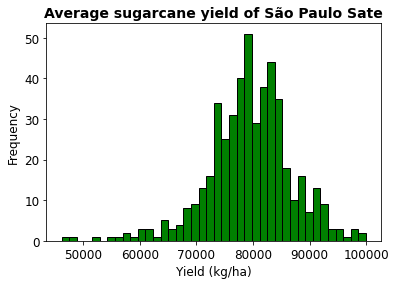

In [38]:
# Histograma da média da produtividade para cada município
plt.hist(dat_yield_clean['mean'], bins = 40, facecolor='green', edgecolor = 'black')
plt.xticks(fontsize=12, color = 'black')
plt.yticks(fontsize=12, color = 'black')
plt.title('Average sugarcane yield of São Paulo Sate', fontsize = 14, fontweight="bold")
plt.xlabel('Yield (kg/ha)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.savefig('plot_average_yield.png', dpi=300)
plt.show()

Uma bela distribuição quase normal! A média da produtividade para todo o estado ronda em torno de 80000 kg/ha.

In [39]:
# Calculando os quantiles
dat_yield_clean['quantiles_yield'] = pd.qcut(x=dat_yield_clean['mean'], q=5, labels=False)
dat_yield_clean.head()

,CD_MUN,MUN,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019,2020,mean,quantiles_yield
0,3500105,Adamantina (SP),50000.0,80000.0,76311.0,77794.0,80000.0,81307.0,75000.0,100000.0,...,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0,75733.90,1
1,3500204,Adolfo (SP),NaN,80000.0,NaN,NaN,120000.0,89009.0,100000.0,100000.0,...,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0,88833.83,4
2,3500303,Aguaí (SP),80000.0,NaN,87000.0,86089.0,86000.0,85434.0,85000.0,85000.0,...,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0,88180.15,4
3,3500550,Águas de Santa Bárbara (SP),NaN,NaN,NaN,NaN,NaN,NaN,80333.0,80000.0,...,100000.0,100000.0,90000.0,63000.0,80000.0,70000.0,75000.0,55000.0,80132.27,2
4,3500709,Agudos (SP),70000.0,70000.0,70000.0,70000.0,77996.0,77723.0,80000.0,88669.0,...,79500.0,60004.0,64794.0,61000.0,70000.0,61000.0,70000.0,70000.0,73318.38,0


In [ ]:
# Salvar o csv
dat_yield_clean.to_csv('dat_clean_yield_mean_quantiles.csv')

Os quantis que foram calculados no paso anterior agora podem ser utilizados para agrupar as outras tabelas

In [40]:
# Adicionar a coluna dos quantis as demais tabelas, para facilitar o agrupamento
dat_ap_clean['quantiles'] = dat_yield_clean['quantiles_yield']
dat_ac_clean['quantiles'] = dat_yield_clean['quantiles_yield']
dat_qp_clean['quantiles'] = dat_yield_clean['quantiles_yield']
dat_vp_clean['quantiles'] = dat_yield_clean['quantiles_yield']
aet_new['quantiles'] = dat_yield_clean['quantiles_yield']
ndvi_new['quantiles'] = dat_yield_clean['quantiles_yield']
npp_new['quantiles'] = dat_yield_clean['quantiles_yield']
soil_new['quantiles'] = dat_yield_clean['quantiles_yield']
pr_new['quantiles'] = dat_yield_clean['quantiles_yield']
lst_new['quantiles'] = dat_yield_clean['quantiles_yield']
tmmx_new['quantiles'] = dat_yield_clean['quantiles_yield']
tmin_new['quantiles'] = dat_yield_clean['quantiles_yield']

In [41]:
# Agrupando os quantiles
aet_new.drop(['CD_MUN'], axis = 1, inplace = True)
ndvi_new.drop(['CD_MUN'], axis = 1, inplace = True)
npp_new.drop(['CD_MUN'], axis = 1, inplace = True)
soil_new.drop(['CD_MUN'], axis = 1, inplace = True)
pr_new.drop(['CD_MUN'], axis = 1, inplace = True)
lst_new.drop(['CD_MUN'], axis = 1, inplace = True)
tmmx_new.drop(['CD_MUN'], axis = 1, inplace = True)
tmin_new.drop(['CD_MUN'], axis = 1, inplace = True)

yield_grouped = dat_yield_clean.groupby('quantiles_yield').mean().round(0).astype(int).reset_index()
ap_grouped = dat_ap_clean.groupby('quantiles').mean().round(0).astype(int).reset_index()
ac_grouped = dat_ac_clean.groupby('quantiles').mean().round(0).astype(int).reset_index()
qp_grouped = dat_qp_clean.groupby('quantiles').mean().round(0).astype(int).reset_index()
vp_grouped = dat_vp_clean.groupby('quantiles').mean().round(0).astype(int).reset_index()
aet_grouped = aet_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
ndvi_grouped = ndvi_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
npp_grouped = npp_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
soil_grouped = soil_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
pr_grouped = pr_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
lst_grouped = lst_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
tmmx_grouped = tmmx_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
tmin_grouped = tmin_new.groupby('quantiles').mean().round(0).astype(int).reset_index()
yield_grouped


,quantiles_yield,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,mean
0,0,65799,66738,64080,65146,66405,66168,68600,68854,69642,...,70600,72141,67590,70493,70658,70722,69994,70908,70851,68805
1,1,73683,73119,75198,77278,77669,78719,81389,80038,79073,...,75176,77529,70124,73000,75394,74861,73614,73841,74815,76237
2,2,74812,78316,79181,78861,80452,80884,81175,84783,84190,...,79020,79438,71563,75295,78237,78922,77540,76291,77569,79575
3,3,80359,79011,81160,83336,85100,86835,87060,87819,88254,...,80853,83018,75470,79202,82645,82560,80277,79043,79978,83012
4,4,86921,85098,88606,91267,88716,91107,98620,94965,93757,...,84567,87934,79144,83597,86716,87598,86182,82912,85295,89226


In [42]:
# Reshape todos os dados com os quantis
yield_grouped = yield_grouped.drop(['mean'], axis = 1)
yield_grouped_melt = pd.melt(yield_grouped, id_vars = ["quantiles_yield"])
ap_grouped_melt = pd.melt(ap_grouped, id_vars = ["quantiles"])
ap_grouped_melt.rename(columns = {'variable': 'Year', 'value': 'AP'}, inplace = True)
ac_grouped_melt = pd.melt(ac_grouped, id_vars = ["quantiles"])
ac_grouped_melt.rename(columns = {'variable': 'Year', 'value': 'AC'}, inplace = True)
qp_grouped_melt = pd.melt(qp_grouped, id_vars = ["quantiles"])
qp_grouped_melt.rename(columns = {'variable': 'Year', 'value': 'QP'}, inplace = True)
vp_grouped_melt = pd.melt(vp_grouped, id_vars = ["quantiles"])
vp_grouped_melt.rename(columns = {'variable': 'Year', 'value': 'VP'}, inplace = True)

aet_grouped_melt = pd.melt(aet_grouped, id_vars =["quantiles"]).reset_index(drop = True)
aet_grouped_melt.rename(columns = {'value': 'AET'}, inplace = True)
ndvi_grouped_melt = pd.melt(ndvi_grouped, id_vars =["quantiles"]).reset_index(drop = True)
ndvi_grouped_melt.rename(columns = {'value': 'NDVI'}, inplace = True)
npp_grouped_melt = pd.melt(npp_grouped, id_vars =["quantiles"]).reset_index(drop = True)
npp_grouped_melt.rename(columns = {'value': 'NPP'}, inplace = True)
soil_grouped_melt = pd.melt(soil_grouped, id_vars =["quantiles"]).reset_index(drop = True)
soil_grouped_melt.rename(columns = {'value': 'SOIL'}, inplace = True)
pr_grouped_melt = pd.melt(pr_grouped, id_vars =["quantiles"]).reset_index(drop = True)
pr_grouped_melt.rename(columns = {'value': 'PR'}, inplace = True)
lst_grouped_melt = pd.melt(lst_grouped, id_vars =["quantiles"]).reset_index(drop = True)
lst_grouped_melt.rename(columns = {'value': 'LST'}, inplace = True)
tmmx_grouped_melt = pd.melt(tmmx_grouped, id_vars =["quantiles"]).reset_index(drop = True)
tmmx_grouped_melt.rename(columns = {'value': 'TMMX'}, inplace = True)
tmin_grouped_melt = pd.melt(tmin_grouped, id_vars =["quantiles"]).reset_index(drop = True)
tmin_grouped_melt.rename(columns = {'value': 'TMIN'}, inplace = True)

In [43]:
yield_grouped_melt.head()

,quantiles_yield,variable,value
0,0,2000,65799
1,1,2000,73683
2,2,2000,74812
3,3,2000,80359
4,4,2000,86921


In [44]:
# Juntar todos os dados
new_data_quantiles = yield_grouped_melt.join([ap_grouped_melt['AP'], ac_grouped_melt['AC'], qp_grouped_melt['QP'], 
                                              vp_grouped_melt['VP'], aet_grouped_melt['AET'], ndvi_grouped_melt['NDVI'], 
                                              npp_grouped_melt['NPP'], soil_grouped_melt['SOIL'], tmin_grouped_melt['TMIN'], 
                                              tmmx_grouped_melt['TMMX'], pr_grouped_melt['PR']])
print('O conjunto de dados limpo tem {} linhas e {} colunas)'.format(new_data_quantiles.shape[0], new_data_quantiles.shape[1]))

O conjunto de dados limpo tem 105 linhas e 14 colunas)


In [45]:
new_data_quantiles.head()

,quantiles_yield,variable,value,AP,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR
0,0.0,2000,65799.0,3554.0,3554.0,234130.0,4177.0,724,5604,8286,275,150,270,102
1,1.0,2000,73683.0,7822.0,7822.0,560907.0,10007.0,713,5379,6662,249,156,278,101
2,2.0,2000,74812.0,7119.0,7119.0,542044.0,9670.0,713,5309,6687,277,156,279,102
3,3.0,2000,80359.0,8446.0,8446.0,669874.0,11951.0,700,5286,6800,302,158,280,104
4,4.0,2000,86921.0,6659.0,6659.0,556949.0,9936.0,698,5233,6377,271,158,281,101


In [ ]:
# Salvar o csv
new_data_quantiles['quantiles_yield'] = new_data_quantiles['quantiles_yield'].astype(int)
new_data_quantiles.to_csv('new_data_quantiles.csv')

### Plotando alguns gráficos

#### Produtividade por ano

In [46]:
# Groupby dos dados do dat_yield_melt
mean_yield = pd.DataFrame(dat_yield_melt.groupby('Year')['Yield'].mean().reset_index())
std_yield = pd.DataFrame(dat_yield_melt.groupby('Year')['Yield'].std().reset_index())
mean_st_merged = mean_yield.merge(std_yield, left_index=True, right_index=True)
mean_st_merged.drop('Year_y', axis = 1, inplace = True)
mean_st_merged.rename(columns = {"Year_x": 'Year', "Yield_x": "mean_yield", 'Yield_y': 'st_yield'}, inplace = True)
mean_st_merged['Year'] = pd.to_datetime(mean_st_merged['Year'], format = '%Y')
mean_st_merged['mean_yield'] = mean_st_merged['mean_yield'].astype(int)
mean_st_merged['st_yield'] = mean_st_merged['st_yield'].astype(int)
mean_st_merged.head()

,Year,mean_yield,st_yield
0,2000-01-01,75969,13500
1,2001-01-01,76309,12431
2,2002-01-01,77228,12757
3,2003-01-01,78786,15468
4,2004-01-01,79643,11929


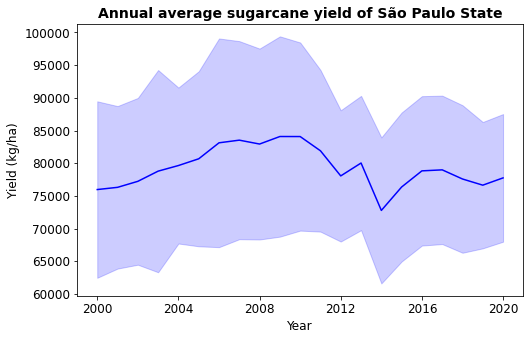

In [47]:
## Plotar o gráfico da média e o desvio padrão por ano
mean_plus_st = mean_st_merged['mean_yield'] +  mean_st_merged['st_yield']
mean_minus_st = mean_st_merged['mean_yield'] -  mean_st_merged['st_yield']

plt.figure(figsize=(8, 5))
plt.plot(mean_st_merged['Year'], mean_st_merged['mean_yield'], color = 'blue')
plt.fill_between(mean_st_merged['Year'], mean_plus_st, mean_minus_st, alpha = 0.2, color = 'blue')
plt.title("Annual average sugarcane yield of São Paulo State", fontsize = 14, fontweight="bold")
plt.xticks(fontsize=12, color = 'black')
plt.yticks(fontsize=12, color = 'black')
plt.xlabel("Year", fontsize = 12)
plt.ylabel("Yield (kg/ha)", fontsize = 12)
plt.savefig('average_yield.png', dpi=300)

plt.show()

#### Area plantada por ano

In [48]:
# Groupby dos dados do dat_yield_melt
mean_ap = pd.DataFrame(dat_ap_melt.groupby('Year')['AP'].mean().reset_index())
std_ap = pd.DataFrame(dat_ap_melt.groupby('Year')['AP'].std().reset_index())
mean_st_merged_ap = mean_ap.merge(std_ap, left_index=True, right_index=True)
mean_st_merged_ap.drop('Year_y', axis = 1, inplace = True)
mean_st_merged_ap.rename(columns = {"Year_x": 'Year', "AP_x": "mean_ap", 'AP_y': 'st_ap'}, inplace = True)
mean_st_merged_ap['Year'] = pd.to_datetime(mean_st_merged_ap['Year'], format = '%Y')
mean_st_merged_ap['mean_yield'] = mean_st_merged_ap['mean_ap'].astype(int)
mean_st_merged_ap['st_yield'] = mean_st_merged_ap['st_ap'].astype(int)
mean_st_merged_ap.head()

,Year,mean_ap,st_ap,mean_yield,st_yield
0,2000-01-01,6786.046448,8483.676832,6786,8483
1,2001-01-01,7027.652055,8840.817004,7027,8840
2,2002-01-01,6584.188119,8346.088141,6584,8346
3,2003-01-01,6935.879310,9081.539003,6935,9081
4,2004-01-01,6939.421176,9147.623462,6939,9147


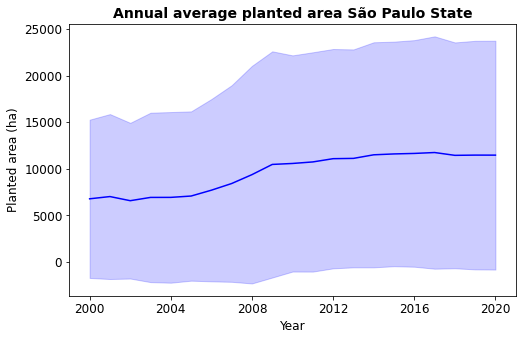

In [49]:
## Plotar o gráfico da média e o desvio padrão por ano
mean_plus_st_ap = mean_st_merged_ap['mean_ap'] +  mean_st_merged_ap['st_ap']
mean_minus_st_ap = mean_st_merged_ap['mean_ap'] -  mean_st_merged_ap['st_ap']

plt.figure(figsize=(8, 5))
plt.plot(mean_st_merged_ap['Year'], mean_st_merged_ap['mean_ap'], color = 'blue')
plt.fill_between(mean_st_merged_ap['Year'], mean_plus_st_ap, mean_minus_st_ap, alpha = 0.2, color = 'blue')
plt.title("Annual average planted area São Paulo State", fontsize = 14, fontweight="bold")
plt.xticks(fontsize=12, color = 'black')
plt.yticks(fontsize=12, color = 'black')
plt.xlabel("Year", fontsize = 12)
plt.ylabel("Planted area (ha)", fontsize = 12)
plt.savefig('average_ap.png', dpi=300)

plt.show()

#### Area colhida por ano

In [50]:
# Groupby dos dados do dat_yield_melt
mean_ac = pd.DataFrame(dat_ac_melt.groupby('Year')['AC'].mean().reset_index())
std_ac = pd.DataFrame(dat_ac_melt.groupby('Year')['AC'].std().reset_index())
mean_st_merged_ac = mean_ac.merge(std_ac, left_index=True, right_index=True)
mean_st_merged_ac.drop('Year_y', axis = 1, inplace = True)
mean_st_merged_ac.rename(columns = {"Year_x": 'Year', "AC_x": "mean_ac", 'AC_y': 'st_ac'}, inplace = True)
mean_st_merged_ac['Year'] = pd.to_datetime(mean_st_merged_ap['Year'], format = '%Y')
mean_st_merged_ac['mean_ac'] = mean_st_merged_ac['mean_ac'].astype(int)
mean_st_merged_ac['st_ac'] = mean_st_merged_ac['st_ac'].astype(int)
mean_st_merged_ac.head()

,Year,mean_ac,st_ac
0,2000-01-01,6786,8483
1,2001-01-01,7027,8840
2,2002-01-01,6582,8347
3,2003-01-01,6935,9081
4,2004-01-01,6939,9147


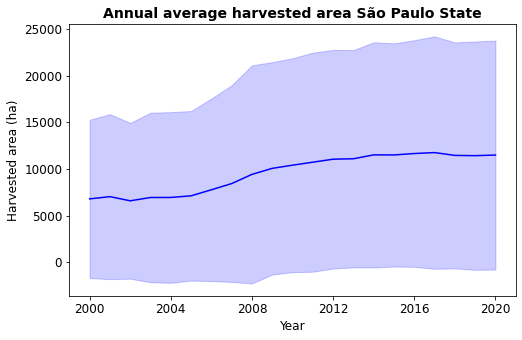

In [51]:
## Plotar o gráfico da média e o desvio padrão por ano
mean_plus_st_ac = mean_st_merged_ac['mean_ac'] +  mean_st_merged_ac['st_ac']
mean_minus_st_ac = mean_st_merged_ac['mean_ac'] -  mean_st_merged_ac['st_ac']

plt.figure(figsize=(8, 5))
plt.plot(mean_st_merged_ac['Year'], mean_st_merged_ac['mean_ac'], color = 'blue')
plt.fill_between(mean_st_merged_ac['Year'], mean_plus_st_ac, mean_minus_st_ac, alpha = 0.2, color = 'blue')
plt.title("Annual average harvested area São Paulo State", fontsize = 14, fontweight="bold")
plt.xticks(fontsize=12, color = 'black')
plt.yticks(fontsize=12, color = 'black')
plt.xlabel("Year", fontsize = 12)
plt.ylabel("Harvested area (ha)", fontsize = 12)
plt.savefig('average_ac.png', dpi=300)

plt.show()

#### Quantidade produzida por ano

In [58]:
# Groupby dos dados do dat_yield_melt
mean_qp = pd.DataFrame(dat_qp_melt.groupby('Year')['QP'].mean().reset_index())
std_qp = pd.DataFrame(dat_qp_melt.groupby('Year')['QP'].std().reset_index())
mean_st_merged_qp = mean_qp.merge(std_qp, left_index=True, right_index=True)
mean_st_merged_qp.drop('Year_y', axis = 1, inplace = True)
mean_st_merged_qp.rename(columns = {"Year_x": 'Year', "QP_x": "mean_qp", 'QP_y': 'st_qp'}, inplace = True)
mean_st_merged_qp['Year'] = pd.to_datetime(mean_st_merged_qp['Year'], format = '%Y')
mean_st_merged_qp['mean_qp'] = mean_st_merged_qp['mean_qp'].astype(int)
mean_st_merged_qp['st_qp'] = mean_st_merged_qp['st_qp'].astype(int)
mean_st_merged_qp.head()

,Year,mean_qp,st_qp
0,2000-01-01,516337,632533
1,2001-01-01,544707,690764
2,2002-01-01,526267,693463
3,2003-01-01,561279,761149
4,2004-01-01,563170,757974


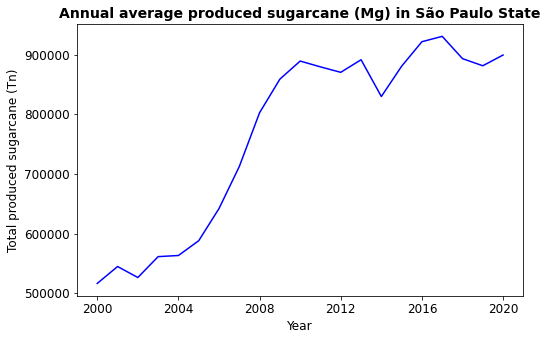

In [69]:
## Plotar o gráfico da média e o desvio padrão por ano
mean_plus_st_qp = mean_st_merged_qp['mean_qp'] +  mean_st_merged_qp['st_qp']
#mean_minus_st_qp = mean_st_merged_qp['mean_qp'] -  mean_st_merged_qp['st_qp']

plt.figure(figsize=(8, 5))
plt.plot(mean_st_merged_qp['Year'], mean_st_merged_qp['mean_qp'], color = 'blue')
#plt.fill_between(mean_st_merged_qp['Year'], mean_plus_st_qp, mean_minus_st_qp, alpha = 0.2, color = 'blue')
plt.title("Annual average produced sugarcane (Mg) in São Paulo State", fontsize = 14, fontweight="bold")
plt.xticks(fontsize=12, color = 'black')
plt.yticks(fontsize=12, color = 'black')
plt.xlabel("Year", fontsize = 12)
plt.ylabel("Total produced sugarcane (Tn)", fontsize = 12)
plt.savefig('average_qp.png', dpi=300)

plt.show()

#### VP por ano

In [53]:
# Groupby dos dados do dat_yield_melt
mean_vp = pd.DataFrame(dat_vp_melt.groupby('Year')['VP'].mean().reset_index())
std_vp = pd.DataFrame(dat_vp_melt.groupby('Year')['VP'].std().reset_index())
mean_st_merged_vp = mean_vp.merge(std_vp, left_index=True, right_index=True)
mean_st_merged_vp.drop('Year_y', axis = 1, inplace = True)
mean_st_merged_vp.rename(columns = {"Year_x": 'Year', "VP_x": "mean_vp", 'VP_y': 'st_vp'}, inplace = True)
mean_st_merged_vp['Year'] = pd.to_datetime(mean_st_merged_vp['Year'], format = '%Y')
mean_st_merged_vp['mean_vp'] = mean_st_merged_vp['mean_vp'].astype(int)
mean_st_merged_vp['st_vp'] = mean_st_merged_vp['st_vp'].astype(int)
mean_st_merged_vp.head()

,Year,mean_vp,st_vp
0,2000-01-01,9211,11284
1,2001-01-01,13458,17082
2,2002-01-01,16035,21129
3,2003-01-01,17351,23225
4,2004-01-01,15323,21571


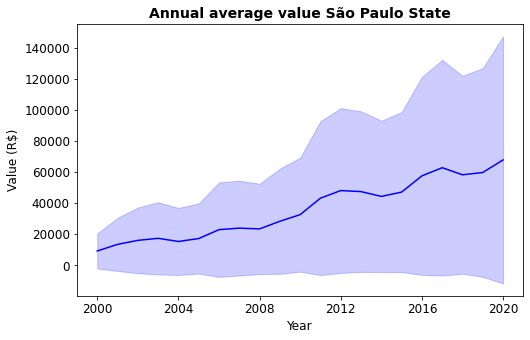

In [54]:
## Plotar o gráfico da média e o desvio padrão por ano
mean_plus_st_vp = mean_st_merged_vp['mean_vp'] +  mean_st_merged_vp['st_vp']
mean_minus_st_vp = mean_st_merged_vp['mean_vp'] -  mean_st_merged_vp['st_vp']

plt.figure(figsize=(8, 5))
plt.plot(mean_st_merged_vp['Year'], mean_st_merged_vp['mean_vp'], color = 'blue')
plt.fill_between(mean_st_merged_vp['Year'], mean_plus_st_vp, mean_minus_st_vp, alpha = 0.2, color = 'blue')
plt.title("Annual average value São Paulo State", fontsize = 14, fontweight="bold")
plt.xticks(fontsize=12, color = 'black')
plt.yticks(fontsize=12, color = 'black')
plt.xlabel("Year", fontsize = 12)
plt.ylabel("Value (R$)", fontsize = 12)
plt.savefig('average_vp.png', dpi=300)

plt.show()

#### Produtividade por quantil por ano

In [ ]:
# Reorganizar os dados - Transponer
yield_grouped.drop(['quantiles_yield'], axis = 1, inplace = True)
dat_clean_grouped_trans = yield_grouped.T
dat_clean_grouped_trans.rename(columns = {0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
dat_clean_grouped_trans.index = pd.to_datetime(dat_clean_grouped_trans.index)
dat_clean_grouped_trans.head()

In [ ]:
## Plot dos quantis
legenda = np.array(["Q1","Q2","Q3","Q4", "Q5"])
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(dat_clean_grouped_trans)
ax.legend(labels=legenda, fontsize = 14)
plt.title("Annual average sugarcane yield per quantile in São Paulo State", fontsize = 14, fontweight="bold")
plt.xticks(fontsize=14, color = 'black')
plt.yticks(fontsize=14, color = 'black')
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Yield (kg/ha)", fontsize = 14)
plt.savefig('average_yield_by_quantiles.png', dpi=300)
plt.show()

In [ ]:
quantiles_grouped_melt = pd.melt(dat_clean_grouped).rename(columns = {'variable': 'Year', 'value': 'Yield'})
quantiles_grouped_melt.to_csv("quantiles_yield_melt.csv")

### Parte 2: Carregar e plotar os rasters

In [ ]:
# Carregar o shapefile do Municipio
sp = gp.read_file('SP_Municipios_2021.shp')
sp.plot(fc = 'white', ec = 'black')
plt.show()

In [ ]:
NDVIStack = xarray.open_rasterio("raster/NDVI_2000-2021.tif")
NDVIStack.shape

In [ ]:
with rasterio.open("raster/NDVI_2000-2021.tif") as NDVI_stack:
    NDVI_stack_data = NDVI_stack.read()
    NDVI_stack_meta = NDVI_stack.profile
    
with rasterio.open("raster/LST_2000-2021.tif") as LST_stack:
    LST_stack_data = LST_stack.read()
    LST_stack_meta = LST_stack.profile
    
with rasterio.open("raster/tmin_bands.tif") as tmin_stack:
    tmin_stack_data = tmin_stack.read()
    tmin_stack_meta = tmin_stack.profile
    
with rasterio.open("raster/tmmx_bands.tif") as tmmx_stack:
    tmmx_stack_data = tmmx_stack.read()
    tmmx_stack_meta = tmmx_stack.profile
    
with rasterio.open("raster/soil_bands.tif") as soil_stack:
    soil_stack_data = soil_stack.read()
    soil_stack_meta = soil_stack.profile
    
with rasterio.open("raster/pr_bands.tif") as pr_stack:
    pr_stack_data = pr_stack.read()
    pr_stack_meta = pr_stack.profile
    
with rasterio.open("raster/aet_bands.tif") as aet_stack:
    aet_stack_data = aet_stack.read()
    aet_stack_meta = aet_stack.profile

In [ ]:
band_titles=list(range(2000, 2022))

ep.plot_bands(NDVI_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

In [ ]:
ep.plot_bands(LST_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

In [ ]:
ep.plot_bands(tmin_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

In [ ]:
ep.plot_bands(tmmx_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()   

In [ ]:
ep.plot_bands(soil_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

In [ ]:
band_titles=list(range(2000, 2022))

ep.plot_bands(aet_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

In [ ]:
band_titles=list(range(2000, 2022))

ep.plot_bands(pr_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()